## Setup

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt
import numpy as np
%load_ext autoreload
%autoreload 2

pt.update_plot_defaults()

# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=False,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',
                                        train=False, download=False,
                                        transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))
    
MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))
    
# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train, shuffle=True, generator=data_generator)
train_sub_dataloader = torch.utils.data.DataLoader(MNIST_train[0:10000], shuffle=True, generator=data_generator)
val_dataloader = torch.utils.data.DataLoader(MNIST_train[-10000:], batch_size=10000, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False)

epochs = 1
data_seed = 0
network_seed = 42

/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


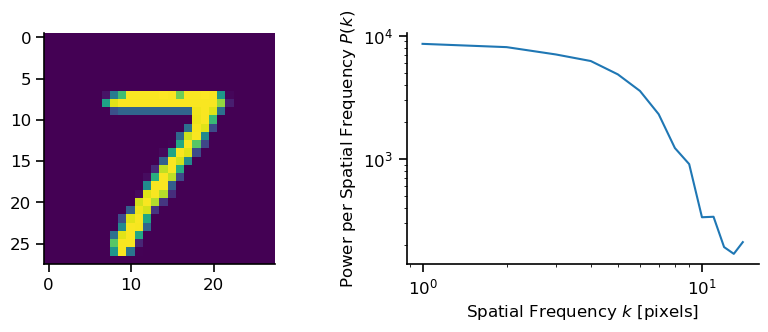

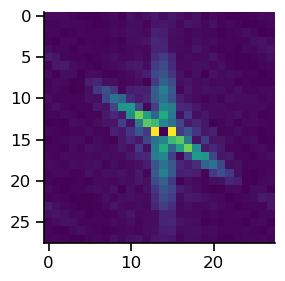

In [71]:
idx, data, target = next(iter(train_dataloader))
image = data[0].reshape(28,28)

frequencies, spectral_power, peak_spatial_frequency = ut.compute_PSD(image, plot=True)

img1 = image.numpy()
freq1 = np.abs(np.fft.fftshift(np.fft.fft2(img1 - np.mean(img1))))
plt.imshow(freq1)


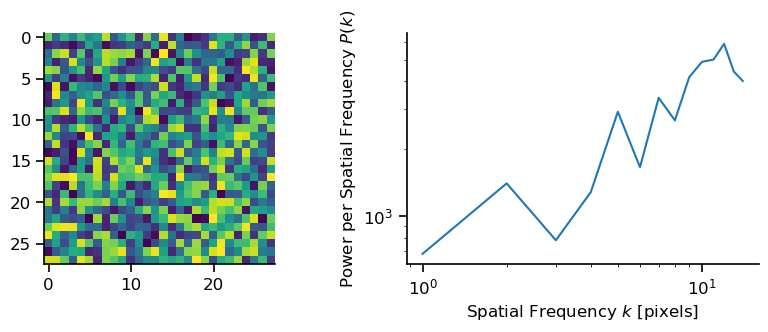

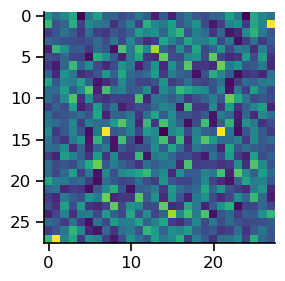

In [73]:
noise = noise = np.random.uniform(0, 1, (28, 28))
frequencies, spectral_power, peak_spatial_frequency = ut.compute_PSD(noise, plot=True)

img2 = noise
freq2 = np.abs(np.fft.fftshift(np.fft.fft2(img2 - np.mean(img2))))
plt.imshow(freq2)

In [75]:
from scipy import signal, stats

img1 = noise*0
freq1 = np.abs(np.fft.fftshift(np.fft.fft2(img1 - np.mean(img1))))

signal.correlate2d(freq1, freq2, mode='valid')[0][0]


0.0

In [76]:
a =torch.tensor([1,2,3,4,5,6,7,8,9,10])
not torch.all(a == 0)

tensor(False)

In [77]:
np.nan/3

nan

-1.8538680669117364 10.03541735972647


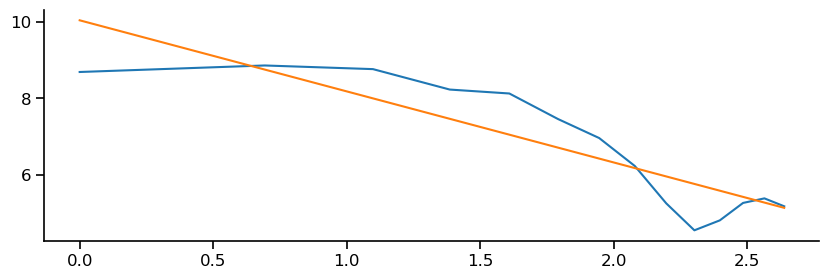

In [70]:
# Fit a line to the log-log plot of the power spectrum
log_freq = np.log(frequencies)
log_power = np.log(spectral_power)
slope, intercept = np.polyfit(log_freq, log_power, 1)
print(slope, intercept)

plt.plot(log_freq, log_power)
plt.plot(log_freq, slope*log_freq + intercept)


# Dale's Backprop network

In [2]:
# Create network
network_name = "20230815_EIANN_1_hidden_mnist_bpDale_config_G_optimized.yaml"
network_config = ut.read_from_yaml(f'../config/MNIST/{network_name}')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

Loading model data from 'saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps.pkl'...
Loading parameters into the network...
Model successfully loaded from 'saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps.pkl'
Batch accuracy = 85.79000091552734%


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:621: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:654: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


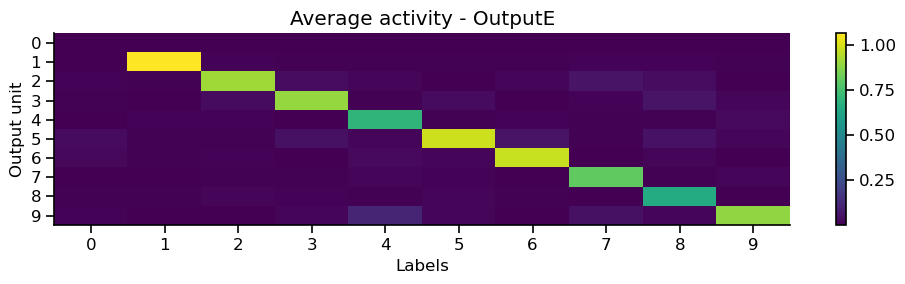

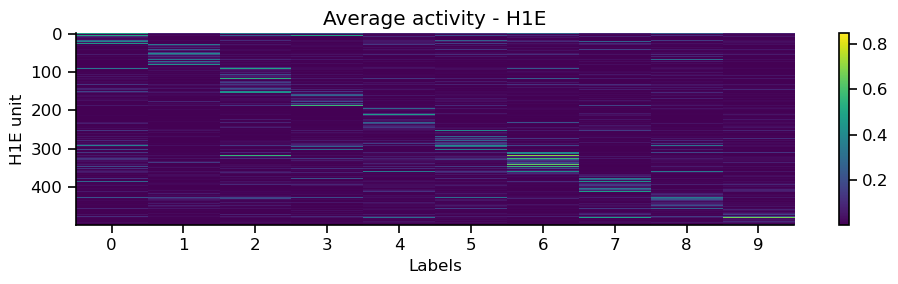

In [4]:
# Load pretrained network
saved_network_path = f"saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps.pkl"
bp_network.load(saved_network_path)

pt.plot_batch_accuracy(bp_network, test_dataloader, population=bp_network.H1.E)
# pt.plot_rsm(bp_network,test_dataloader)

In [5]:
# # Train network
# data_generator.manual_seed(data_seed)
# bp_network.train(train_sub_dataloader, 
#                               test_dataloader, 
#                               epochs=epochs,
#                               val_interval=(0,-1,1000),
#                               store_history=True, 
#                               store_params=False,
#                               status_bar=True)

# bp_network.save(file_name_base=network_name)

# pt.plot_batch_accuracy(bp_network, test_dataloader, population=bp_network.H1.E)
# plt.figure()
# pt.plot_train_loss_history(bp_network)
# plt.show()

# # pt.plot_test_loss_history(bp_network, test_dataloader, stepsize=50)
# plt.figure()
# plt.plot(bp_network.val_loss_history)
# plt.title('Loss')
# plt.show()

Computing tuning strength...


/Users/ag1880/opt/anaconda3/lib/python3.8/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Generating plots...
W_min = 0.0, W_max = 0.17123501002788544


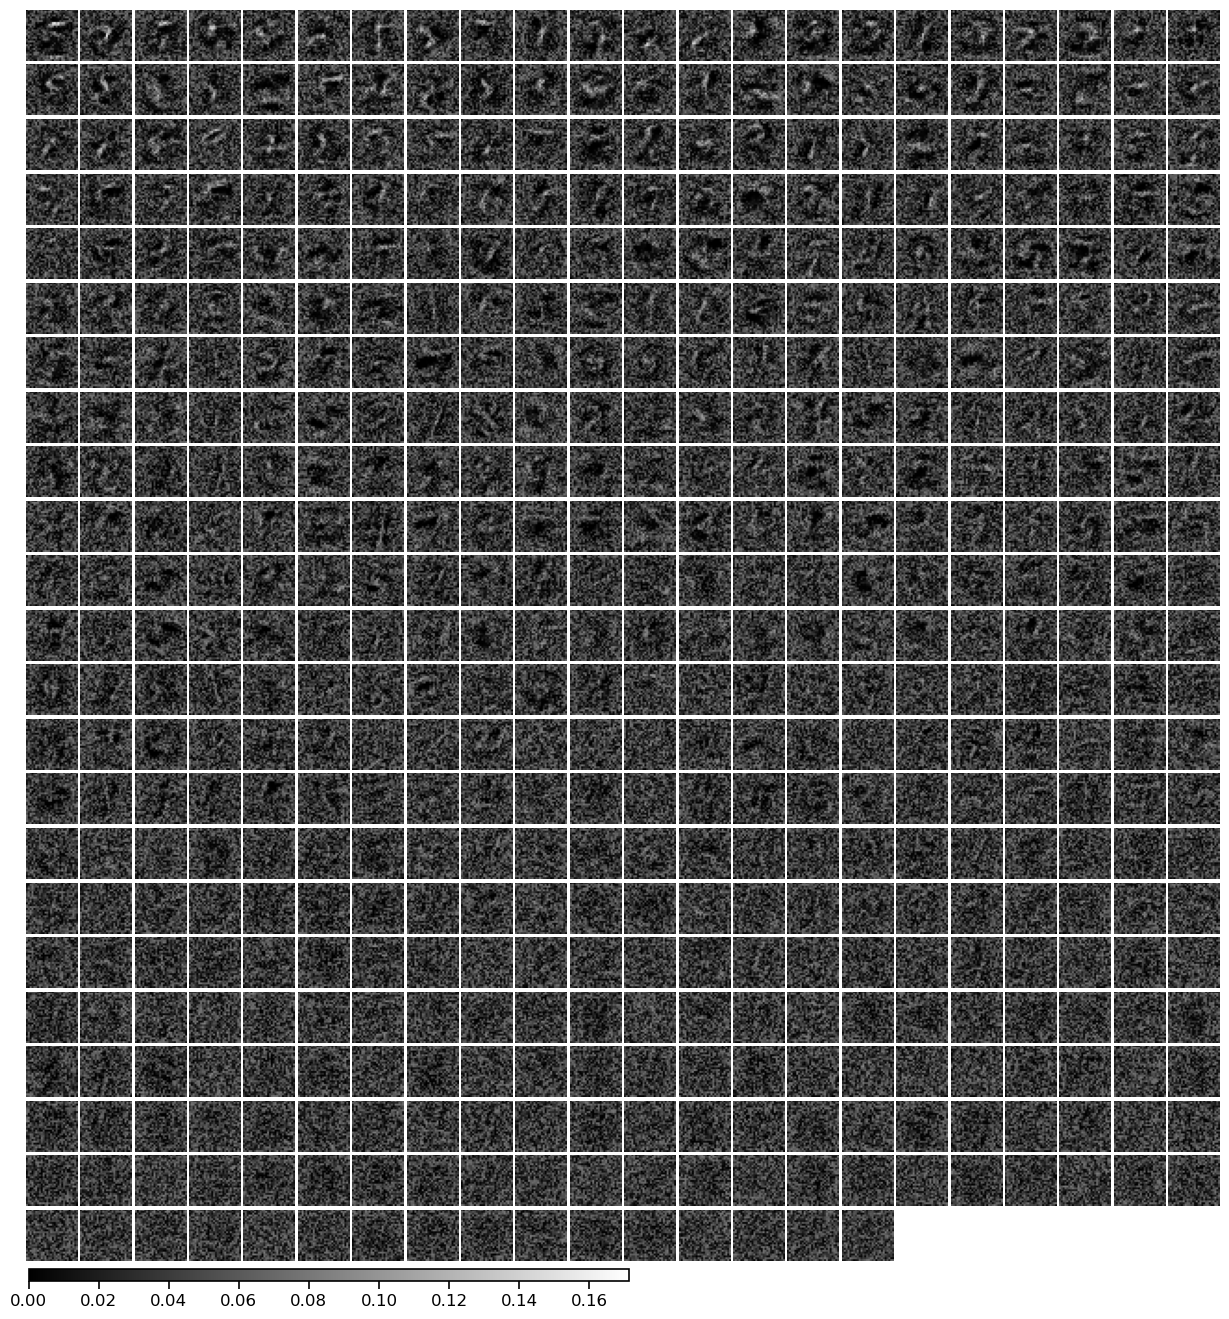

In [55]:
pt.plot_hidden_weights(bp_network.module_dict['H1E_InputE'].weight, sort=True) 

/Users/ag1880/opt/anaconda3/lib/python3.8/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


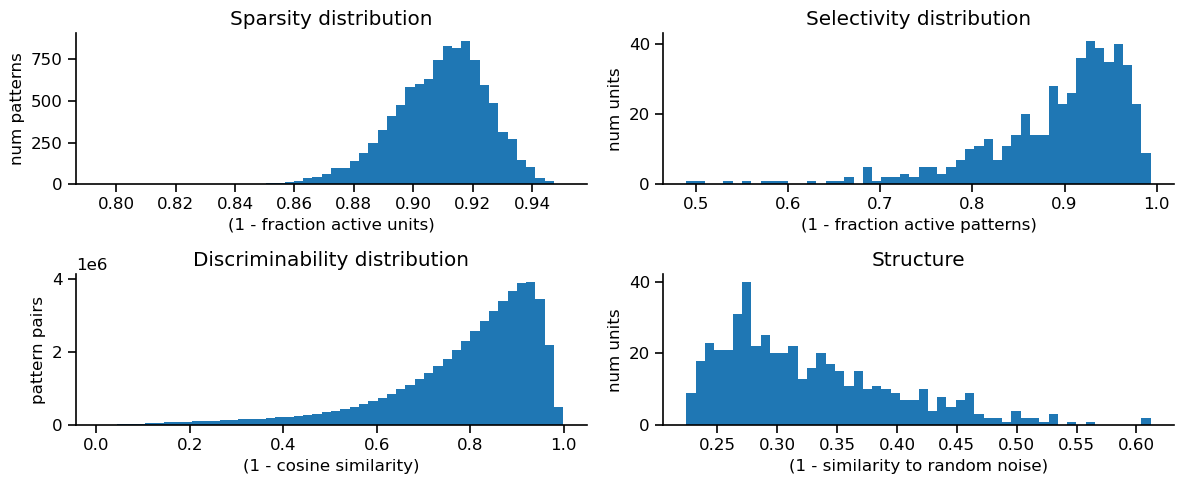

In [56]:
network = bp_network
weights = network.module_dict['H1E_InputE'].weight.detach()

# population = network.H1.E
# receptive_fields, _ = ut.compute_maxact_receptive_fields(population, test_dataloader, sigmoid=False)
metrics_dict = ut.compute_representation_metrics(network.H1.E, test_dataloader, receptive_fields=weights, plot=True)
# metrics_dict['val_loss'] =  network.val_loss_history
# metrics_dict['val_loss_steps'] = network.val_history_train_steps
# ut.export_metrics_data(metrics_dict, network_name, path='saved_networks/model_metrics')

Computing tuning strength...
Generating plots...
W_min = 0.0, W_max = 0.17123501002788544


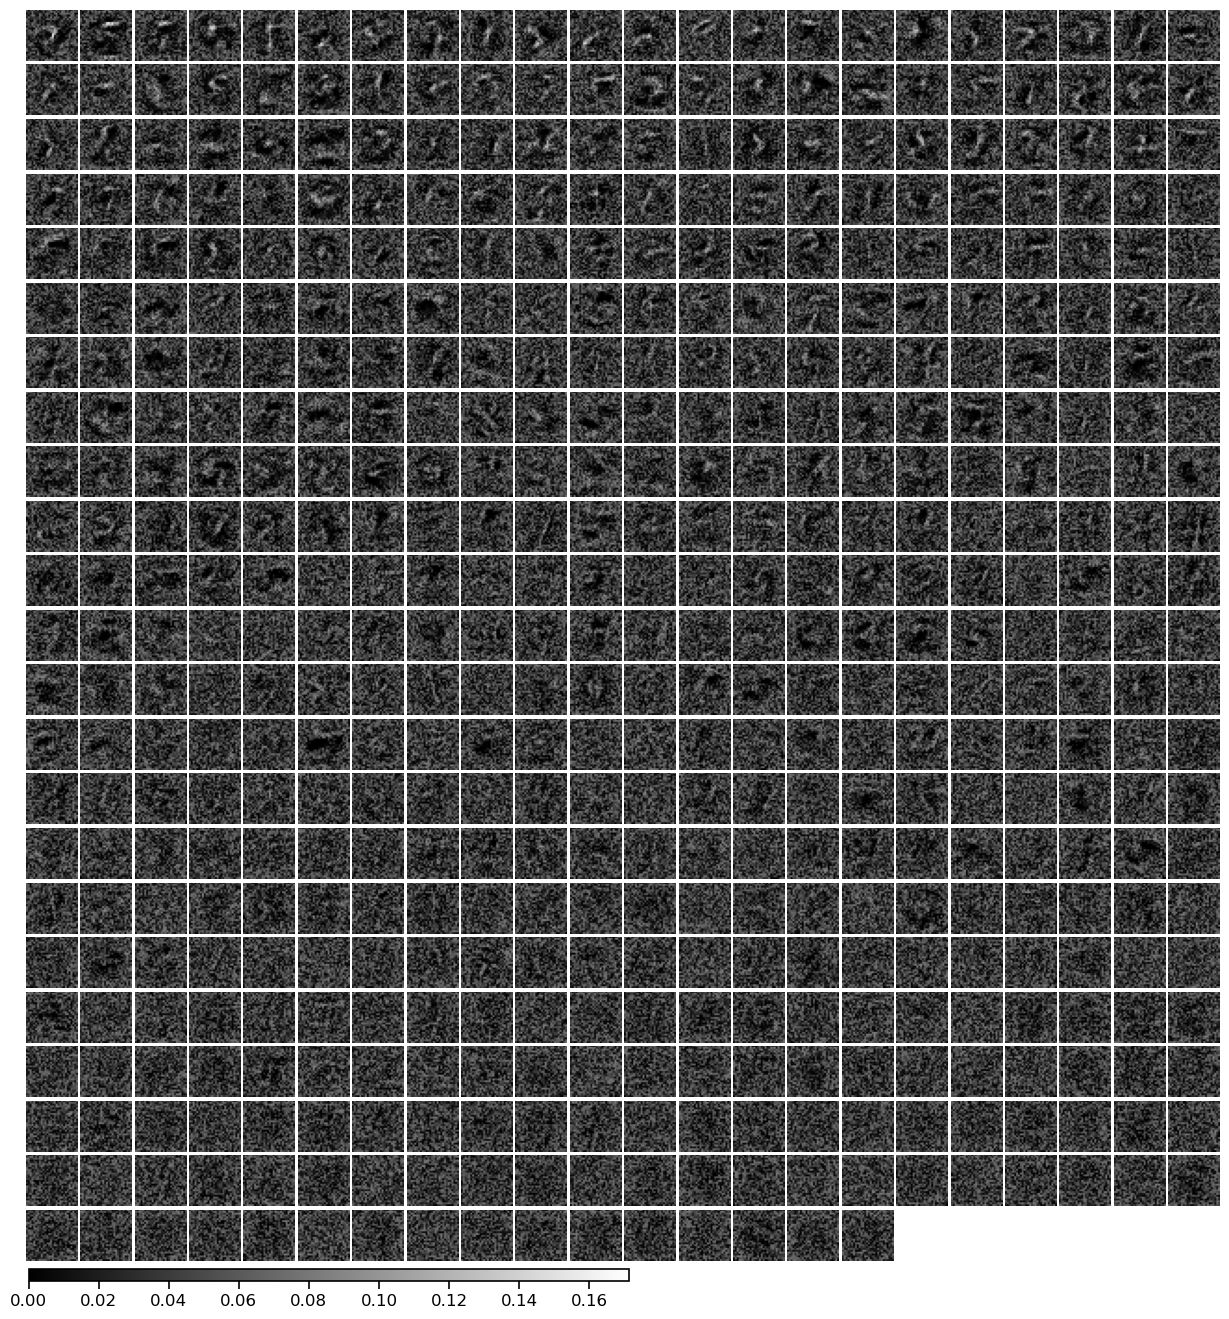

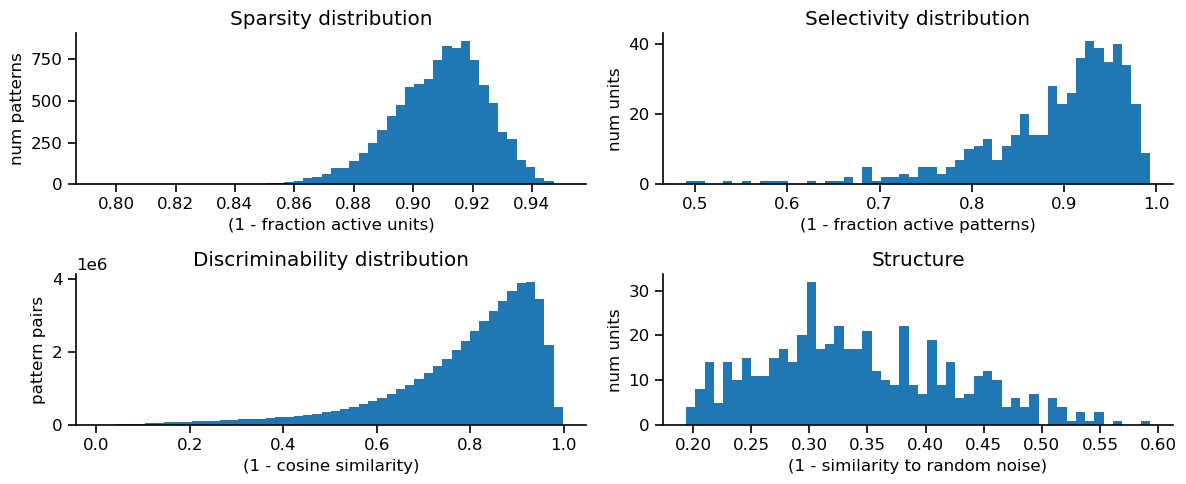

In [57]:
# FFT
pt.plot_hidden_weights(bp_network.module_dict['H1E_InputE'].weight, sort=True) 
metrics_dict = ut.compute_representation_metrics(network.H1.E, test_dataloader, receptive_fields=weights, plot=True)


Structure: 0.3293280168423639


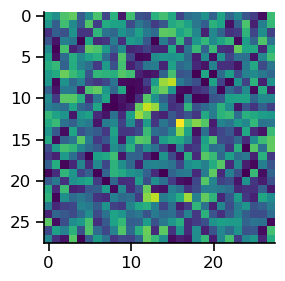

In [52]:
i = 2
w = weights[i]
plt.imshow(w.reshape(28,28))
print('Structure:', structure[i])

In [24]:
from skimage import metrics
noise = np.random.uniform(min(w), max(w), (28, 28))
metrics.structural_similarity(w.view(28, 28).numpy(), noise)

/Users/ag1880/opt/anaconda3/lib/python3.8/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


0.659367923401604